In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wave,os,librosa,tqdm,time,warnings
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [ ]:
cre = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/CREMA_D_OpenSMILE_4_Emotions.csv')
cref = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/CREMA_D_OpenSMILE_Fear_Emotion.csv')
emo = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/EMODB_OpenSMILE_Features.csv')
rav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/RAVDESS_OpenSMILE_Features.csv')
sav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/SAVEE_OpenSMILE_Features.csv')
iem = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/IEMOCAP_OpenSMILE_Features_2.csv')
iem2 = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/IEMOCAP_OpenSMILE_Features.csv')

In [ ]:
cre = cre.drop(['Unnamed: 0'], axis=1)
cref = cref.drop(['Unnamed: 0'], axis=1)

In [ ]:
cref.isnull().sum().sum()

0

In [ ]:
for d in [cre,cref,emo,rav,sav,iem,iem2]:
  print(d.shape)

(4900, 6374)
(1271, 6374)
(535, 6374)
(1440, 6374)
(480, 6374)
(7529, 6374)
(7529, 6374)


In [ ]:
import pandas as pd
cre = pd.concat([cre, cref], axis=0)
cre.shape

(6171, 6374)

In [ ]:
cre.to_csv("/content/drive/MyDrive/PBL_2_Files/CREMA_D_OpenSMILE_5_Emotions_Trim_then_NR.csv")

In [ ]:
for d in [cre,emo,rav,sav,iem]:
  print(d['label'].value_counts())

label
happy      1271
sad        1271
angry      1271
fear       1271
neutral    1087
Name: count, dtype: int64
label
angry      127
boredom     81
neutral     79
happy       71
fear        69
sad         62
disgust     46
Name: count, dtype: int64
label
calm         192
happy        192
sad          192
angry        192
fear         192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64
label
Neutral      120
anger         60
disgust       60
fear          60
happiness     60
sadness       60
surprise      60
Name: count, dtype: int64
label
frustrated    1849
neutral       1708
happy         1636
angry         1103
sad           1084
surprised      107
fear            40
disgust          2
Name: count, dtype: int64


In [ ]:
sav['label'] = sav['label'].replace({'Neutral': 'neutral', 'anger': 'angry', 'happiness': 'happy', 'sadness': 'sad'})
sav['label'].value_counts()

,count
label,
neutral,120
angry,60
disgust,60
fear,60
happy,60
sad,60
surprise,60


In [ ]:
import pandas as pd
dfs = [cre, emo, rav, sav, iem]
labels_to_keep = ['angry', 'happy', 'sad', 'fear', 'neutral']
full = pd.DataFrame()
for df in dfs:
  df_filtered = df[df['label'].isin(labels_to_keep)]
  full = pd.concat([full, df_filtered], axis=0)
print(full.shape)
print(full['label'].value_counts())

(13374, 6374)
label
happy      3230
neutral    3090
angry      2753
sad        2669
fear       1632
Name: count, dtype: int64


In [ ]:
full.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,0.450796,0.339744,0.666667,0.023399,0.030485,0.190735,0.007086,0.160250,0.167335,0.016857,...,0.578092,1.746136,1.748039,-19.999828,0.462072,85.607530,38.963768,74.27141,41.101090,happy
1,0.582389,0.271605,0.000000,0.108567,0.189416,0.266452,0.080849,0.077037,0.157886,0.022642,...,0.616435,3.013976,2.976359,19.027126,0.601453,105.442880,41.915794,116.73011,62.343582,happy
2,1.827803,0.317073,0.756098,0.416002,0.640309,0.841811,0.224307,0.201502,0.425809,0.134929,...,0.359583,2.687222,2.558891,14.550713,0.446408,106.329480,62.103245,76.49855,28.192270,happy
3,0.527835,0.382253,0.774744,0.011901,0.050679,0.126504,0.038778,0.075825,0.114603,0.006497,...,0.491549,2.752444,2.759875,-19.985146,0.514417,110.441700,46.829490,108.85519,56.959373,sad
4,0.420860,0.344262,0.174863,0.009516,0.017446,0.063877,0.007930,0.046431,0.054361,0.004801,...,0.552896,2.070777,2.068833,19.999931,0.763940,88.900444,36.839695,93.50300,47.209220,sad


In [ ]:
full.to_csv("/content/drive/MyDrive/PBL_2_Files/All_5_Datasets_5_Emotions_OpenSMILE.csv")

In [ ]:
cre = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/CREMA_D_OpenSMILE_5_Emotions_Trim_then_NR.csv')
cre = cre.drop(['Unnamed: 0'], axis=1)
cre = cre[cre['label'].isin(['angry','neutral','happy','sad'])]
cre.shape

(4900, 6374)

In [ ]:
cre.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,0.450796,0.339744,0.666667,0.023399,0.030485,0.190735,0.007086,0.160250,0.167335,0.016857,...,0.578092,1.746136,1.748039,-19.999828,0.462072,85.607530,38.963768,74.27141,41.101090,happy
1,0.582389,0.271605,0.000000,0.108567,0.189416,0.266452,0.080849,0.077037,0.157886,0.022642,...,0.616435,3.013976,2.976359,19.027126,0.601453,105.442880,41.915794,116.73011,62.343582,happy
2,1.827803,0.317073,0.756098,0.416002,0.640309,0.841811,0.224307,0.201502,0.425809,0.134929,...,0.359583,2.687222,2.558891,14.550713,0.446408,106.329480,62.103245,76.49855,28.192270,happy
3,0.527835,0.382253,0.774744,0.011901,0.050679,0.126504,0.038778,0.075825,0.114603,0.006497,...,0.491549,2.752444,2.759875,-19.985146,0.514417,110.441700,46.829490,108.85519,56.959373,sad
4,0.420860,0.344262,0.174863,0.009516,0.017446,0.063877,0.007930,0.046431,0.054361,0.004801,...,0.552896,2.070777,2.068833,19.999931,0.763940,88.900444,36.839695,93.50300,47.209220,sad


In [ ]:
cre2 = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/CREMA_D_OpenSMILE_Features_16khz.csv')
cre2 = cre2[~cre2['label'].isin(['disgust','fear'])]
cre2.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
1,2.842399,0.339744,0.666667,0.144809,0.190776,1.201254,0.045967,1.010477,1.056444,0.101726,...,0.579995,1.852076,1.848551,19.996635,0.463444,86.849070,36.343845,83.875320,35.431065,happy
2,3.580656,0.468254,0.059524,0.047415,0.603700,1.295135,0.556285,0.691435,1.247721,0.017060,...,0.489374,2.647305,2.646941,20.000000,0.587815,88.807236,45.619810,93.137535,50.819130,happy
6,3.208989,0.378947,0.000000,0.395794,0.973355,1.296252,0.577561,0.322896,0.900458,0.117090,...,0.393592,2.749373,2.686679,17.533875,0.482138,95.191220,31.668568,90.445465,31.347220,happy
7,2.942702,0.382253,0.774744,0.057938,0.280278,0.701694,0.222340,0.421417,0.643756,0.024278,...,0.549227,2.721473,2.720835,20.000000,0.519239,123.037285,58.846054,107.189180,53.815920,sad
9,3.456345,0.344262,0.172131,0.062437,0.129049,0.519603,0.066612,0.390555,0.457166,0.014215,...,0.690680,2.751101,2.713722,18.869580,0.479571,98.780330,50.880928,107.447550,59.765316,sad


In [ ]:
cre3 = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/CREMA_D_OpenSMILE_4_emotions_16khz.csv')
cre3.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,7.471000,0.346405,0.679739,0.568054,0.760315,4.447711,0.192261,3.687395,3.879657,0.395412,...,0.601791,1.948433,1.888568,16.472248,0.605425,88.133390,40.995457,72.241960,33.637535,happy
1,7.410002,0.265432,0.000000,2.305475,3.855414,5.069492,1.549939,1.214078,2.764017,0.421083,...,0.492775,2.620636,2.604683,19.797840,0.348975,112.598420,45.614050,106.472670,57.681713,happy
2,6.211867,0.317073,0.756098,2.387648,3.526447,4.521158,1.138799,0.994711,2.133511,0.762943,...,0.554127,2.304971,2.172200,13.612209,0.353783,116.460655,60.848305,78.668550,28.900824,happy
3,8.134696,0.604082,0.808163,0.386192,1.866543,4.401485,1.480351,2.534942,4.015293,0.122200,...,0.360948,2.937568,2.905770,19.255314,0.603260,122.013756,57.233300,114.333410,52.451702,sad
4,8.406446,0.373860,0.182371,0.366802,0.880025,3.374824,0.513223,2.494799,3.008022,0.068103,...,0.522412,2.829177,2.827713,20.000000,0.425862,119.007190,56.996770,99.011215,61.320557,sad


In [ ]:
print(cre.shape,cre3.shape)

(4900, 6374) (4899, 6374)


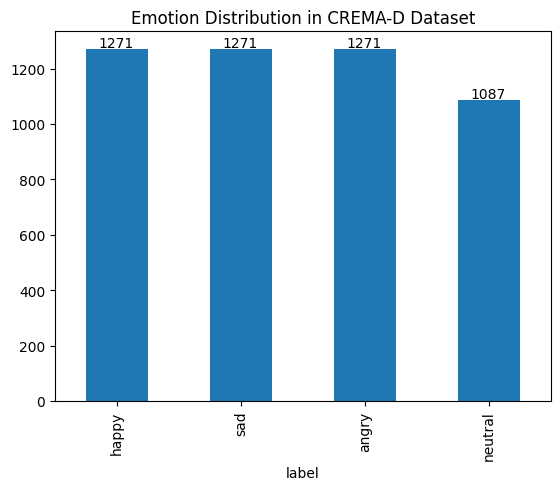

In [ ]:
ax = cre['label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 1.005))
plt.title("Emotion Distribution in CREMA-D Dataset")
plt.show()

In [ ]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=True,onlypreprocess=False,hppms=None):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  print("Train test split done")
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  print("Scaling done")
  if apply_LDA:
    lda = LinearDiscriminantAnalysis()
    trainX = lda.fit_transform(trainX, trainY)
    testX = lda.transform(testX)
    print("LDA Tranformation Done")
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
    print("SMOTE done")
  if onlypreprocess:
    return trainX,trainY,testX,testY
  print("Training model started")
  model.fit(trainX, trainY)
  print("Training model done")
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  if hppms:
    return acc,hppms
  return acc

def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

Train test split done
Scaling done
Training model started
Training model done


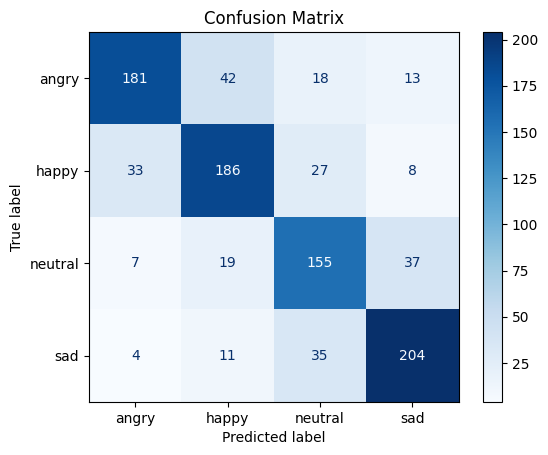


Logistic Regression Accuracy: 74.082%
              precision    recall  f1-score   support

       angry       0.80      0.71      0.76       254
       happy       0.72      0.73      0.73       254
     neutral       0.66      0.71      0.68       218
         sad       0.78      0.80      0.79       254

    accuracy                           0.74       980
   macro avg       0.74      0.74      0.74       980
weighted avg       0.74      0.74      0.74       980



In [ ]:
lr_model = LogisticRegression(C=0.3,class_weight='balanced',max_iter=1000)
acc_lr = preprocess_split_train_test(cre,lr_model,'Logistic Regression',rs=710,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


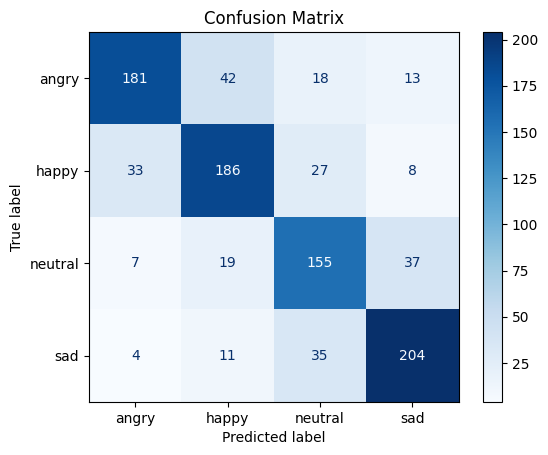


Logistic Regression Accuracy: 74.082%
              precision    recall  f1-score   support

       angry       0.80      0.71      0.76       254
       happy       0.72      0.73      0.73       254
     neutral       0.66      0.71      0.68       218
         sad       0.78      0.80      0.79       254

    accuracy                           0.74       980
   macro avg       0.74      0.74      0.74       980
weighted avg       0.74      0.74      0.74       980



In [ ]:
lr_model = LogisticRegression(C=0.3,class_weight='balanced',max_iter=1000)
acc_lr = preprocess_split_train_test(cre,lr_model,'Logistic Regression',rs=710,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


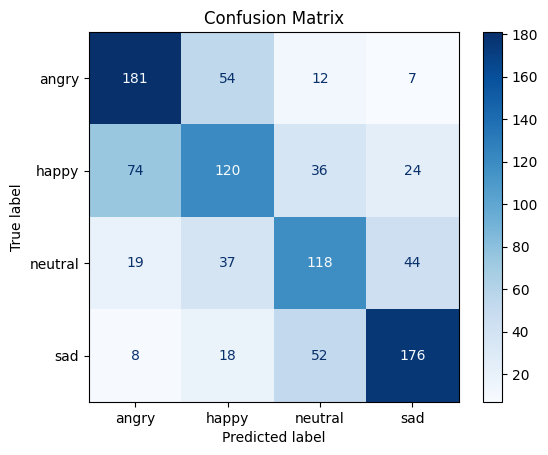


Decision Tree Accuracy: 60.714%
              precision    recall  f1-score   support

       angry       0.64      0.71      0.68       254
       happy       0.52      0.47      0.50       254
     neutral       0.54      0.54      0.54       218
         sad       0.70      0.69      0.70       254

    accuracy                           0.61       980
   macro avg       0.60      0.60      0.60       980
weighted avg       0.60      0.61      0.60       980



In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy',min_samples_split=10,min_samples_leaf=8,random_state=30)
acc_dt = preprocess_split_train_test(cre,dt_model,'Decision Tree',rs=205,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


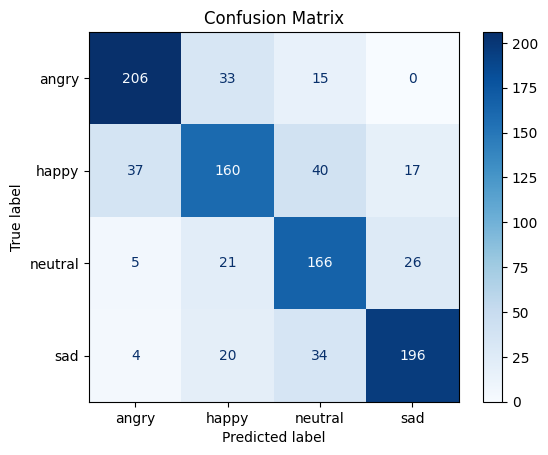


Random Forest Accuracy: 74.286%
              precision    recall  f1-score   support

       angry       0.82      0.81      0.81       254
       happy       0.68      0.63      0.66       254
     neutral       0.65      0.76      0.70       218
         sad       0.82      0.77      0.80       254

    accuracy                           0.74       980
   macro avg       0.74      0.74      0.74       980
weighted avg       0.75      0.74      0.74       980

CPU times: user 4min 34s, sys: 805 ms, total: 4min 34s
Wall time: 4min 39s


In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=700,random_state=24)
acc_rf = preprocess_split_train_test(cre,rf_model,'Random Forest',rs=205,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


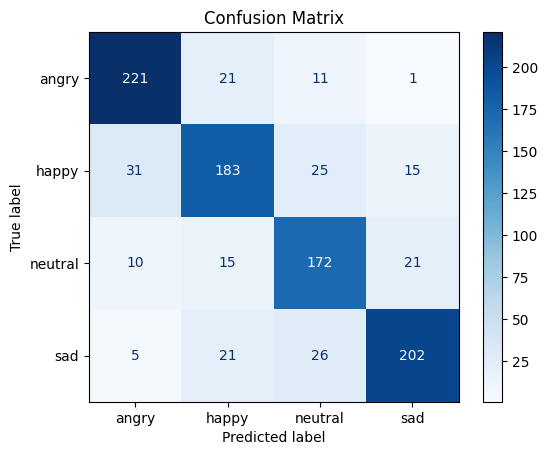


SVM Accuracy: 79.388%
              precision    recall  f1-score   support

       angry       0.83      0.87      0.85       254
       happy       0.76      0.72      0.74       254
     neutral       0.74      0.79      0.76       218
         sad       0.85      0.80      0.82       254

    accuracy                           0.79       980
   macro avg       0.79      0.79      0.79       980
weighted avg       0.79      0.79      0.79       980



In [ ]:
svm_model = SVC(C=2,random_state=42,kernel='rbf')
acc_svm = preprocess_split_train_test(cre,svm_model,'SVM',rs=205,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


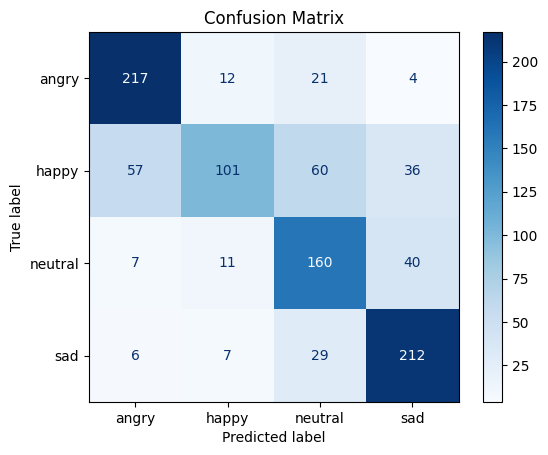


KNN Accuracy: 70.408%
              precision    recall  f1-score   support

       angry       0.76      0.85      0.80       254
       happy       0.77      0.40      0.52       254
     neutral       0.59      0.73      0.66       218
         sad       0.73      0.83      0.78       254

    accuracy                           0.70       980
   macro avg       0.71      0.71      0.69       980
weighted avg       0.72      0.70      0.69       980



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=27)
acc_knn = preprocess_split_train_test(cre,knn_model,'KNN',rs=205,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


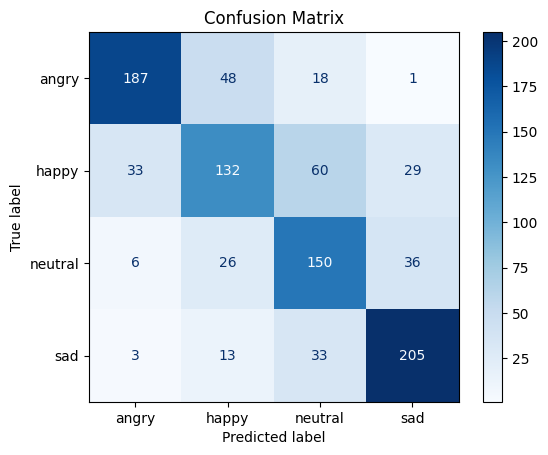


Naive Bayes Accuracy: 68.776%
              precision    recall  f1-score   support

       angry       0.82      0.74      0.77       254
       happy       0.60      0.52      0.56       254
     neutral       0.57      0.69      0.63       218
         sad       0.76      0.81      0.78       254

    accuracy                           0.69       980
   macro avg       0.69      0.69      0.68       980
weighted avg       0.69      0.69      0.69       980



In [ ]:
nb_model = GaussianNB()
acc_nb = preprocess_split_train_test(cre,nb_model,'Naive Bayes',rs=205,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


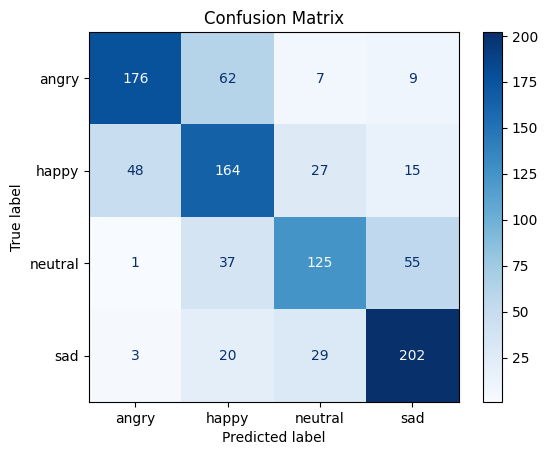


AdaBoost Accuracy: 68.061%
              precision    recall  f1-score   support

       angry       0.77      0.69      0.73       254
       happy       0.58      0.65      0.61       254
     neutral       0.66      0.57      0.62       218
         sad       0.72      0.80      0.76       254

    accuracy                           0.68       980
   macro avg       0.68      0.68      0.68       980
weighted avg       0.68      0.68      0.68       980



In [ ]:
ab_model = AdaBoostClassifier(algorithm='SAMME')
acc_ab = preprocess_split_train_test(cre,ab_model,'AdaBoost',rs=710,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


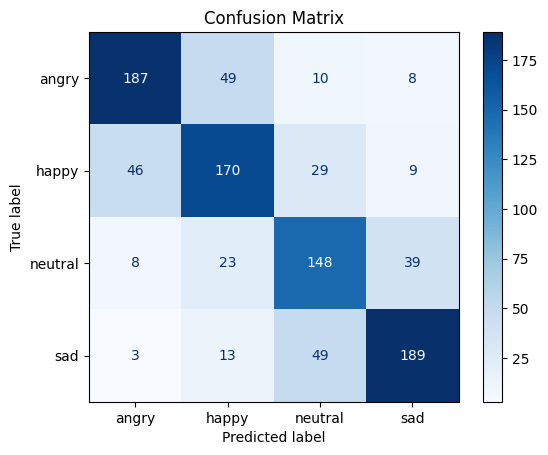


AdaBoost Accuracy: 70.816%
              precision    recall  f1-score   support

       angry       0.77      0.74      0.75       254
       happy       0.67      0.67      0.67       254
     neutral       0.63      0.68      0.65       218
         sad       0.77      0.74      0.76       254

    accuracy                           0.71       980
   macro avg       0.71      0.71      0.71       980
weighted avg       0.71      0.71      0.71       980



In [ ]:
ab_model = AdaBoostClassifier(estimator=lr_model,algorithm='SAMME')
acc_ab = preprocess_split_train_test(cre,ab_model,'AdaBoost',rs=710,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


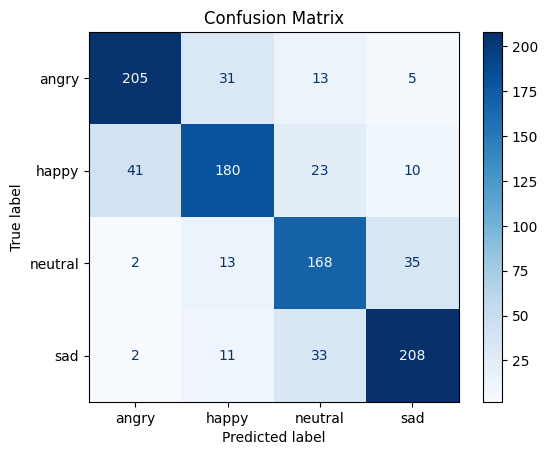


XGBoost Accuracy: 77.653%
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       254
           1       0.77      0.71      0.74       254
           2       0.71      0.77      0.74       218
           3       0.81      0.82      0.81       254

    accuracy                           0.78       980
   macro avg       0.78      0.78      0.78       980
weighted avg       0.78      0.78      0.78       980



In [ ]:
xgb_model = XGBClassifier(tree_method='hist',device='cuda')
acc_xgb = preprocess_split_train_test(cre,xgb_model,'XGBoost',rs=710,apply_LDA=False)

In [ ]:
import concurrent.futures, warnings
warnings.filterwarnings("ignore")
from scipy.stats import randint, uniform
hpr = []
iters = 20
max_acc = 0
best_params = dict()
st = time.time()
param_grid = {
        'learning_rate': uniform(0.01, 0.5-0.01),
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 20),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.3, 1-0.3),
    'colsample_bytree': uniform(0.5, 1-0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 15-1),
    'random_state':randint(0,1000)
          }
params2 = {
        'apply_smote':[False,True],
        #'rs': [i for i in range(0,1000)]
    }
for k in range(iters):
    chosen_params = {param: dist.rvs() for param, dist in param_grid.items()}
    xgb_model = XGBClassifier(device='cuda',**chosen_params)
    chosen_params2 = {param: np.random.choice(values) for param, values in params2.items()}
    print(f"Iter No. - {k}")
    print(f"Model Params = {chosen_params}")
    print(f"Preprocessing Params = {chosen_params2}\n")
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(cre,xgb_model,'XGBoost',rs=710,apply_LDA=False,printres=False,**chosen_params2,hppms=(chosen_params,chosen_params2))
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    chosen_params.update(chosen_params2)
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = chosen_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")

Iter No. - 0
Model Params = {'learning_rate': 0.030964465141755236, 'n_estimators': 52, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.16235394303436324, 'subsample': 0.8471704319259548, 'colsample_bytree': 0.7227391446857953, 'reg_alpha': 0.03359687536762723, 'reg_lambda': 0.5664554769078944, 'scale_pos_weight': 9.505336790946131, 'random_state': 143}
Preprocessing Params = {'apply_smote': True}

Train test split done
Scaling done
SMOTE done
Training model started
Training model done
Time taken = 0 min 26 sec

Current Accuracy = 75.82%
Best Accuracy = 75.82%
Best Params Found so far = {'learning_rate': 0.030964465141755236, 'n_estimators': 52, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.16235394303436324, 'subsample': 0.8471704319259548, 'colsample_bytree': 0.7227391446857953, 'reg_alpha': 0.03359687536762723, 'reg_lambda': 0.5664554769078944, 'scale_pos_weight': 9.505336790946131, 'random_state': 143, 'apply_smote': True}

Iter No. - 1
Model Params = {'learning_rate': 0.2479

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


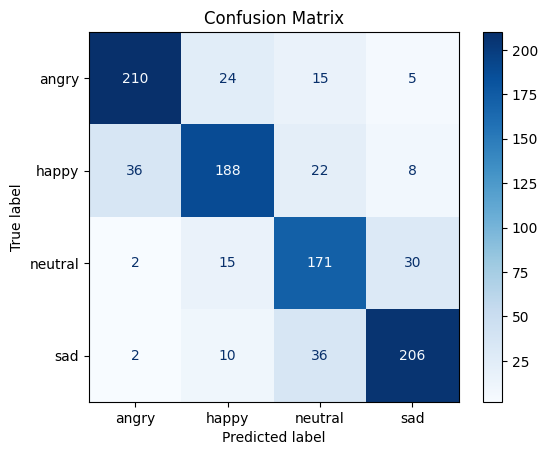


XGBoost Accuracy: 79.082%
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       254
           1       0.79      0.74      0.77       254
           2       0.70      0.78      0.74       218
           3       0.83      0.81      0.82       254

    accuracy                           0.79       980
   macro avg       0.79      0.79      0.79       980
weighted avg       0.79      0.79      0.79       980



In [ ]:
mparams = {'learning_rate': 0.11408291440312202, 'n_estimators': 473, 'max_depth': 3,
           'min_child_weight': 8, 'gamma': 0.46455764578944525, 'subsample': 0.6560871207218952,
           'colsample_bytree': 0.7416346132011201, 'reg_alpha': 0.05953700702320841, 'reg_lambda': 0.21908914481908115,
           'scale_pos_weight': 12.950587278182557, 'random_state': 571}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(cre,xgb_model,'XGBoost',rs=710,apply_smote=True,apply_LDA=False)

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
import optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 10),
        'gamma': trial.suggest_float('gamma', 0.3, 0.6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.4),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 15),
        'random_state': 571
    }
    xgb_model = XGBClassifier(device='cuda', **params)
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(cre, xgb_model, 'XGBoost', rs=710, apply_LDA=False, printres=False,apply_smote=True,hppms=(params,params2))
    return acc_xgb
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print(f"Best Accuracy: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-10-22 20:57:11,795] A new study created in memory with name: no-name-c383a6d7-d04d-4cb9-9c3d-8be9e718a1d4


Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 20:57:40,578] Trial 0 finished with value: 0.7755102040816326 and parameters: {'learning_rate': 0.17045919176029967, 'n_estimators': 550, 'max_depth': 2, 'min_child_weight': 10, 'gamma': 0.33037698526412085, 'subsample': 0.5654749115985541, 'colsample_bytree': 0.7069975308384667, 'reg_alpha': 0.09179531320648716, 'reg_lambda': 0.14487166227786466, 'scale_pos_weight': 11.846588586892196}. Best is trial 0 with value: 0.7755102040816326.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 20:58:00,753] Trial 1 finished with value: 0.7877551020408163 and parameters: {'learning_rate': 0.1349598626153871, 'n_estimators': 597, 'max_depth': 1, 'min_child_weight': 5, 'gamma': 0.4700208661679225, 'subsample': 0.5205587902338962, 'colsample_bytree': 0.885874457562368, 'reg_alpha': 0.0733658374828368, 'reg_lambda': 0.12031436101893561, 'scale_pos_weight': 11.109955324765643}. Best is trial 1 with value: 0.7877551020408163.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 20:59:04,420] Trial 2 finished with value: 0.7908163265306123 and parameters: {'learning_rate': 0.06150982172598289, 'n_estimators': 517, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.43914592440375644, 'subsample': 0.796246599838118, 'colsample_bytree': 0.8894981634486654, 'reg_alpha': 0.03271557475345182, 'reg_lambda': 0.17310282714001962, 'scale_pos_weight': 10.058904727770269}. Best is trial 2 with value: 0.7908163265306123.


Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 20:59:21,316] Trial 3 finished with value: 0.773469387755102 and parameters: {'learning_rate': 0.19597215785106897, 'n_estimators': 452, 'max_depth': 1, 'min_child_weight': 10, 'gamma': 0.41479124224422514, 'subsample': 0.6135964326177252, 'colsample_bytree': 0.769165596808056, 'reg_alpha': 0.09661497797526886, 'reg_lambda': 0.12117872205834644, 'scale_pos_weight': 10.576713347901986}. Best is trial 2 with value: 0.7908163265306123.


Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 20:59:43,906] Trial 4 finished with value: 0.7785714285714286 and parameters: {'learning_rate': 0.18246838369339918, 'n_estimators': 424, 'max_depth': 2, 'min_child_weight': 5, 'gamma': 0.3113262043193704, 'subsample': 0.6431646489521006, 'colsample_bytree': 0.6094493827846753, 'reg_alpha': 0.03333546637195608, 'reg_lambda': 0.2621070038531299, 'scale_pos_weight': 14.852994665257548}. Best is trial 2 with value: 0.7908163265306123.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:00:19,068] Trial 5 finished with value: 0.7693877551020408 and parameters: {'learning_rate': 0.1926762263834867, 'n_estimators': 452, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 0.5456282585536213, 'subsample': 0.5274780426575095, 'colsample_bytree': 0.8004001784560335, 'reg_alpha': 0.07532079182917882, 'reg_lambda': 0.38347862519395437, 'scale_pos_weight': 13.62293073119726}. Best is trial 2 with value: 0.7908163265306123.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:01:10,178] Trial 6 finished with value: 0.7724489795918368 and parameters: {'learning_rate': 0.11783129424868337, 'n_estimators': 583, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.4238188537321969, 'subsample': 0.6215698040231439, 'colsample_bytree': 0.7009851414553084, 'reg_alpha': 0.014150453018515807, 'reg_lambda': 0.1819040150932314, 'scale_pos_weight': 10.175273228945828}. Best is trial 2 with value: 0.7908163265306123.


Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:01:51,802] Trial 7 finished with value: 0.7969387755102041 and parameters: {'learning_rate': 0.10505030331610152, 'n_estimators': 570, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.36704109014022457, 'subsample': 0.6487744583029587, 'colsample_bytree': 0.7437508225295962, 'reg_alpha': 0.07910940450160968, 'reg_lambda': 0.21145934378733128, 'scale_pos_weight': 13.230281624182995}. Best is trial 7 with value: 0.7969387755102041.


Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:02:19,317] Trial 8 finished with value: 0.7795918367346939 and parameters: {'learning_rate': 0.14751228865116378, 'n_estimators': 592, 'max_depth': 2, 'min_child_weight': 6, 'gamma': 0.507029817894201, 'subsample': 0.627698984863128, 'colsample_bytree': 0.6109142889138942, 'reg_alpha': 0.08904032803349986, 'reg_lambda': 0.14325804148914884, 'scale_pos_weight': 14.38136040318857}. Best is trial 7 with value: 0.7969387755102041.


Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:03:12,321] Trial 9 finished with value: 0.773469387755102 and parameters: {'learning_rate': 0.13193627190867152, 'n_estimators': 579, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 0.42887129856490547, 'subsample': 0.6775352094500544, 'colsample_bytree': 0.6110382573360558, 'reg_alpha': 0.028419382547717142, 'reg_lambda': 0.12231169419661694, 'scale_pos_weight': 10.935871835311998}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:03:58,059] Trial 10 finished with value: 0.7908163265306123 and parameters: {'learning_rate': 0.08965172482175206, 'n_estimators': 518, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.3644147091829631, 'subsample': 0.7377811026949314, 'colsample_bytree': 0.8191264286868882, 'reg_alpha': 0.05450801038385327, 'reg_lambda': 0.26618233400590685, 'scale_pos_weight': 12.784342046408685}. Best is trial 7 with value: 0.7969387755102041.


Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:05:08,713] Trial 11 finished with value: 0.7948979591836735 and parameters: {'learning_rate': 0.054174754732359824, 'n_estimators': 516, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.365350501051424, 'subsample': 0.7912393142939366, 'colsample_bytree': 0.8931611268439766, 'reg_alpha': 0.05185675153613576, 'reg_lambda': 0.21335686217054095, 'scale_pos_weight': 12.60734614856833}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:06:09,558] Trial 12 finished with value: 0.7857142857142857 and parameters: {'learning_rate': 0.051692280613632326, 'n_estimators': 492, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 0.3697750417816891, 'subsample': 0.6989935858576846, 'colsample_bytree': 0.7140623338923842, 'reg_alpha': 0.05728714595724764, 'reg_lambda': 0.2201286160978931, 'scale_pos_weight': 12.87966892536337}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:06:53,326] Trial 13 finished with value: 0.7908163265306123 and parameters: {'learning_rate': 0.08738616420313904, 'n_estimators': 556, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.5982849028693018, 'subsample': 0.7966718242483174, 'colsample_bytree': 0.8421257071836094, 'reg_alpha': 0.06590390969939579, 'reg_lambda': 0.3142754670177389, 'scale_pos_weight': 12.059126178763796}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:07:46,365] Trial 14 finished with value: 0.7785714285714286 and parameters: {'learning_rate': 0.0866420841528982, 'n_estimators': 545, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.3768728221471606, 'subsample': 0.733350439167018, 'colsample_bytree': 0.7490319434428909, 'reg_alpha': 0.047876129637260866, 'reg_lambda': 0.22042507270555523, 'scale_pos_weight': 13.376943048679816}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:08:22,429] Trial 15 finished with value: 0.7846938775510204 and parameters: {'learning_rate': 0.11063192946067915, 'n_estimators': 488, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.3355298235769779, 'subsample': 0.5732678845906853, 'colsample_bytree': 0.6740532157988393, 'reg_alpha': 0.002234476166123024, 'reg_lambda': 0.30850964150298377, 'scale_pos_weight': 13.745926399545263}. Best is trial 7 with value: 0.7969387755102041.


Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:09:36,964] Trial 16 finished with value: 0.7846938775510204 and parameters: {'learning_rate': 0.06839060670476416, 'n_estimators': 525, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.3945018306295083, 'subsample': 0.7473897459101239, 'colsample_bytree': 0.7615460270730452, 'reg_alpha': 0.08350625935258697, 'reg_lambda': 0.212351370789166, 'scale_pos_weight': 12.14720003327497}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started


[I 2024-10-22 21:10:22,504] Trial 17 finished with value: 0.7816326530612245 and parameters: {'learning_rate': 0.1050028558561813, 'n_estimators': 472, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.476846843850372, 'subsample': 0.6783932324367334, 'colsample_bytree': 0.8522663407770997, 'reg_alpha': 0.044365331383341436, 'reg_lambda': 0.2942229195345968, 'scale_pos_weight': 11.617205817045878}. Best is trial 7 with value: 0.7969387755102041.


Training model done
Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:11:07,262] Trial 18 finished with value: 0.8020408163265306 and parameters: {'learning_rate': 0.07333916340450583, 'n_estimators': 565, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.3056534932872963, 'subsample': 0.5952553393716117, 'colsample_bytree': 0.6569475106732515, 'reg_alpha': 0.06965438167222682, 'reg_lambda': 0.3535917251443661, 'scale_pos_weight': 12.60754709628301}. Best is trial 18 with value: 0.8020408163265306.


Train test split done
Scaling done
SMOTE done
Training model started
Training model done


[I 2024-10-22 21:11:35,278] Trial 19 finished with value: 0.7816326530612245 and parameters: {'learning_rate': 0.07566129388731231, 'n_estimators': 560, 'max_depth': 2, 'min_child_weight': 6, 'gamma': 0.3042783998396506, 'subsample': 0.5823011825564756, 'colsample_bytree': 0.6602124058821749, 'reg_alpha': 0.07878810026034958, 'reg_lambda': 0.3892150848207286, 'scale_pos_weight': 13.273817644398541}. Best is trial 18 with value: 0.8020408163265306.


Best Accuracy: 0.8020408163265306
Best Parameters: {'learning_rate': 0.07333916340450583, 'n_estimators': 565, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.3056534932872963, 'subsample': 0.5952553393716117, 'colsample_bytree': 0.6569475106732515, 'reg_alpha': 0.06965438167222682, 'reg_lambda': 0.3535917251443661, 'scale_pos_weight': 12.60754709628301}


Train test split done
Scaling done
SMOTE done
Training model started
Training model done


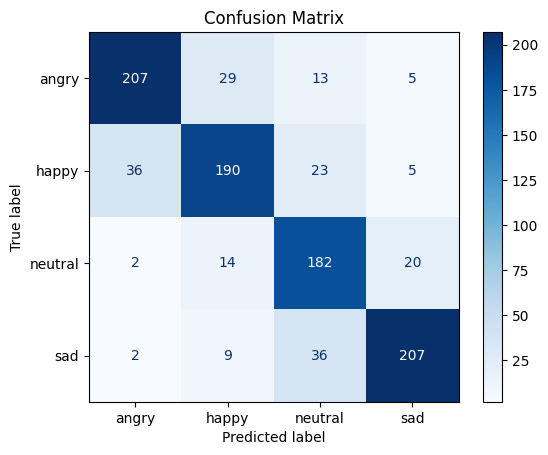


XGBoost Accuracy: 80.204%
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       254
           1       0.79      0.75      0.77       254
           2       0.72      0.83      0.77       218
           3       0.87      0.81      0.84       254

    accuracy                           0.80       980
   macro avg       0.80      0.80      0.80       980
weighted avg       0.81      0.80      0.80       980



In [ ]:
mparams = {'learning_rate': 0.07333916340450583, 'n_estimators': 565, 'max_depth': 3,
           'min_child_weight': 6, 'gamma': 0.3056534932872963, 'subsample': 0.5952553393716117,
           'colsample_bytree': 0.6569475106732515, 'reg_alpha': 0.06965438167222682, 'reg_lambda': 0.3535917251443661, 'scale_pos_weight': 12.60754709628301,'random_state':571}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(cre,xgb_model,'XGBoost',rs=710,apply_smote=True,apply_LDA=False)